In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import geopandas as gpd
from shapely.geometry import Point

import time


# %matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.20, 's' : 35, 'linewidth':0.0}

# Data Cleaning steps

In [2]:
df = pd.read_csv("./Data/Liquor_Licenses.csv")

In [3]:
recode = ['BREW_PUB', 'ENTERTAINMENT',
       'SALES_CONSUMPTION', 'SIDEWALK_CAFE', 'SUMMER_GARDEN', 'TASTING',
       'WINE_PUB', 'COVERCHARGE', 'DANCING',
       'OFFPREMISESTORAGE', 'STORAGEFACILITY', 'DISTILLERY_PUB','GAMES_OF_SKILL',
          'SPORTS_WAGGERING']
df[recode] = df[recode].replace({np.nan:0,'CHECKED':1 })


In [4]:
#Replace TYPE
df.TYPE = df.TYPE.replace({'Retail-Class B': 'Retail - Class B',
                'Retail-Liquor Store':'Retail - Liquor Store',
                 'Retail-Full Service Grocery':'Retail - Full Service Grocery'})

In [5]:
# # Replace WARD

# df.WARD = df.WARD.replace({'Ward 1':1, 'Ward 2':2, 'Ward 3':3,'Ward 4':4,
#                           'Ward 5':5, 'Ward 6':6, 'Ward 7':7,'Ward 8':8})


In [6]:
dup_list = df[df.duplicated(subset='LICENSE')].LICENSE.to_list()
dup = df[df.LICENSE.isin(dup_list)]
# Drop duplicates for License and address
df = df.drop_duplicates(subset = ['LICENSE','ADDRESS'], keep = 'last')
# Drop once again to get rid of the row with wrong address for Gallaudet
df = df.drop_duplicates(subset = ['LICENSE'], keep = 'first')

In [7]:
df.TYPE.unique()

array(['Restaurant', 'Multipurpose', 'Retail - Liquor Store',
       'Retail - Grocery', 'Tavern', 'Hotel', 'Club', 'Nightclub',
       'Marine Vessel', 'Retail - Full Service Grocery', 'Wholesaler',
       'Arena', 'Caterer', 'Internet', 'Retail - Class B', 'Manufacturer',
       '25 Percent', 'Beer and Wine', 'Railroad'], dtype=object)

In [8]:
df.columns

Index(['OBJECTID', 'LICENSE', 'TRADE_NAME', 'APPLICANT', 'CLASS', 'ADDRESS',
       'ADDRID', 'X', 'Y', 'STATUS', 'TYPE', 'BREW_PUB', 'ENTERTAINMENT',
       'SALES_CONSUMPTION', 'SIDEWALK_CAFE', 'SUMMER_GARDEN', 'TASTING',
       'WINE_PUB', 'WARD', 'ZIPCODE', 'SMD', 'ANC', 'COVERCHARGE', 'DANCING',
       'OFFPREMISESTORAGE', 'STORAGEFACILITY', 'DISTILLERY_PUB', 'LONGITUDE',
       'LATITUDE', 'TOTAL_CAPACITY', 'GAMES_OF_SKILL', 'SPORTS_WAGGERING'],
      dtype='object')

In [9]:
# df['ESTAB'] = np.where(df.BREW_PUB == 1,'BREW_PUB',df.ESTAB)
# df['ESTAB'] = np.where(df.ENTERTAINMENT == 1,'ENTERTAINMENT',df.ESTAB)
# df['ESTAB'] = np.where(df.SALES_CONSUMPTION == 1,'SALES_CONSUMPTION',df.ESTAB)
# df['ESTAB'] = np.where(df.SIDEWALK_CAFE == 1,'SIDEWALK_CAFE',df.ESTAB)
# df['ESTAB'] = np.where(df.SUMMER_GARDEN == 1,'SUMMER_GARDEN',df.ESTAB)
# df['ESTAB'] = np.where(df.TASTING == 1,'TASTING',df.ESTAB)
# df['ESTAB'] = np.where(df.WINE_PUB == 1,'WINE_PUB',df.ESTAB)

In [10]:
# df['ESTAB'] = 'OTHER'
# df.loc[df.BREW_PUB == 1, df.ESTAB] = 'BREW_PUB'
# df.loc[df.ENTERTAINMENT == 1, df.ESTAB] = 'ENTERTAINMENT'
# df.loc[df.SALES_CONSUMPTION == 1, df.ESTAB] = 'SALES_CONSUMPTION'
# df.loc[df.SIDEWALK_CAFE == 1, df.ESTAB] = 'SIDEWALK_CAFE'
# df.loc[df.SUMMER_GARDEN == 1, df.ESTAB] = 'SUMMER_GARDEN'
# df.loc[df.TASTING == 1, df.ESTAB] = 'TASTING'
# df.loc[df.WINE_PUB == 1, df.ESTAB] = 'WINE_PUB'


# Set up geom stuff

In [11]:
# Number of kilometers in one radian
kms_per_radian = 6371.0088

# represent points consistently as (lat, lon)
coords = df[['LATITUDE', 'LONGITUDE']].values

# Convert list of lat & lon to radians
X = np.radians(coords)

In [12]:
# dc_map = gpd.read_file('./Shapefiles/Washington_DC_Boundary.shp')
# dc_map.plot

In [13]:
# ward = gpd.read_file('./Shapefiles/Ward_from_2012.shp')
# ward.plot()

In [14]:
# neighborhood = gpd.read_file('./Shapefiles/Neighborhood_Clusters.shp')
# neighborhood.plot()

In [15]:
geo = [Point(xy) for xy in zip(df['LONGITUDE'], df['LATITUDE'])]
geo_df = gpd.GeoDataFrame(df, geometry = geo)

Text(0.5, 1.0, 'Map of liquor license holders in Washington DC divided by ward')

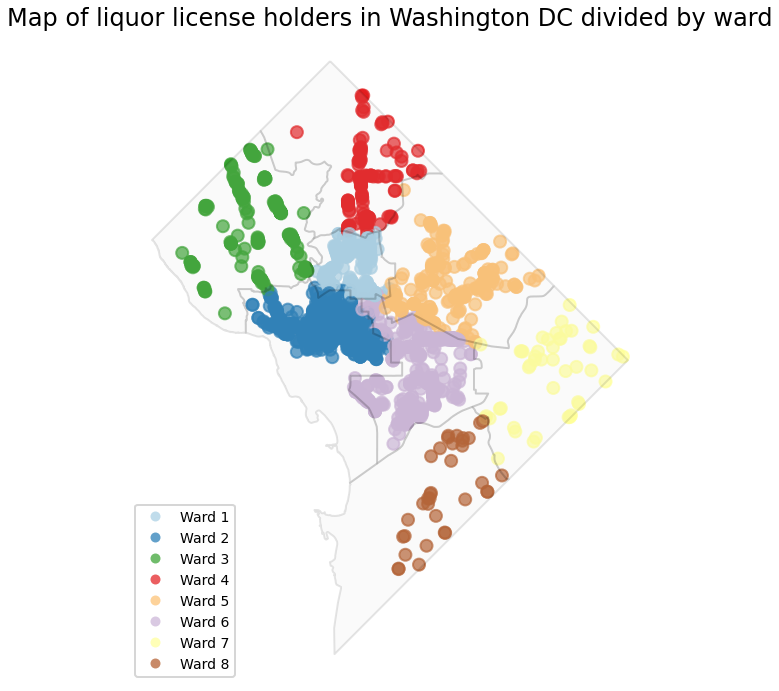

In [16]:
# Color by ward
fig, ax= plt.subplots(figsize = (12,12))
geo_df.plot(column = 'WARD', ax= ax, legend = True, legend_kwds={'loc': 'lower left','fontsize':14},
            cmap = 'Paired', alpha = 0.7)
ward = gpd.read_file('./Shapefiles/Ward_from_2012.shp')
ward.plot(ax=ax, alpha=0.1, edgecolor='black', color='lightgrey', zorder=2)
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)
# Remove the black box
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.title("Map of liquor license holders in Washington DC divided by ward")

# Introducing spatial clustering techniques: DBSCAN and HDBSCAN

Text(0.5, 1.0, 'Map of liquor license holders in Washington DC divided by neighbordhoods')

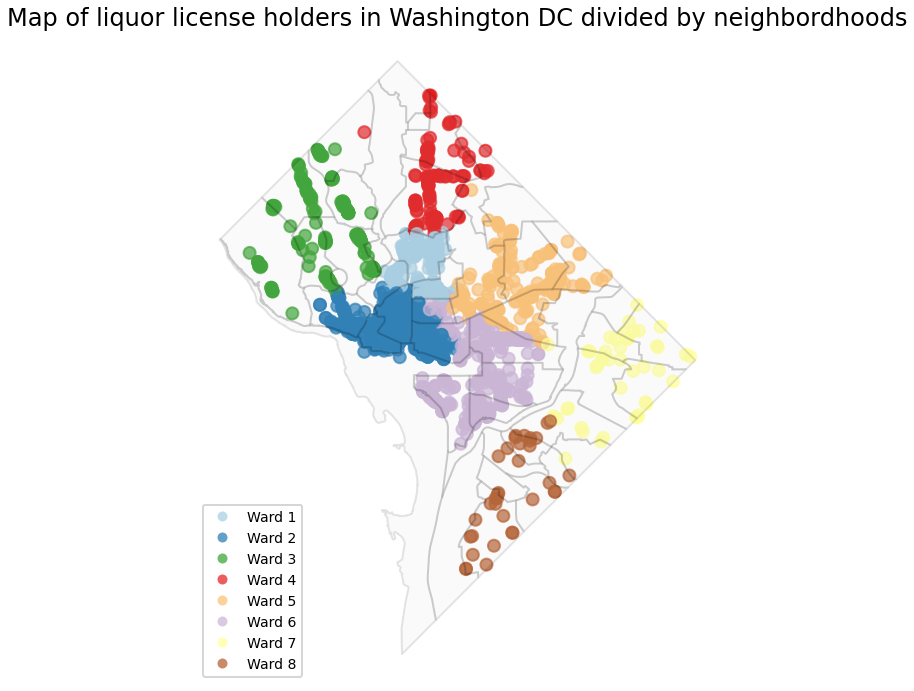

In [17]:
# Color by ward
fig, ax= plt.subplots(figsize = (12,12))
geo_df.plot(column = 'WARD', ax= ax, legend = True, legend_kwds={'loc': 'lower left','fontsize':14},
            cmap = 'Paired', alpha = 0.7)
neighborhood = gpd.read_file('./Shapefiles/Neighborhood_Clusters.shp')
neighborhood.plot(ax=ax, alpha=0.1, edgecolor='black', color='lightgrey', zorder=2)
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)
# Remove the black box
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.title("Map of liquor license holders in Washington DC divided by neighbordhoods")


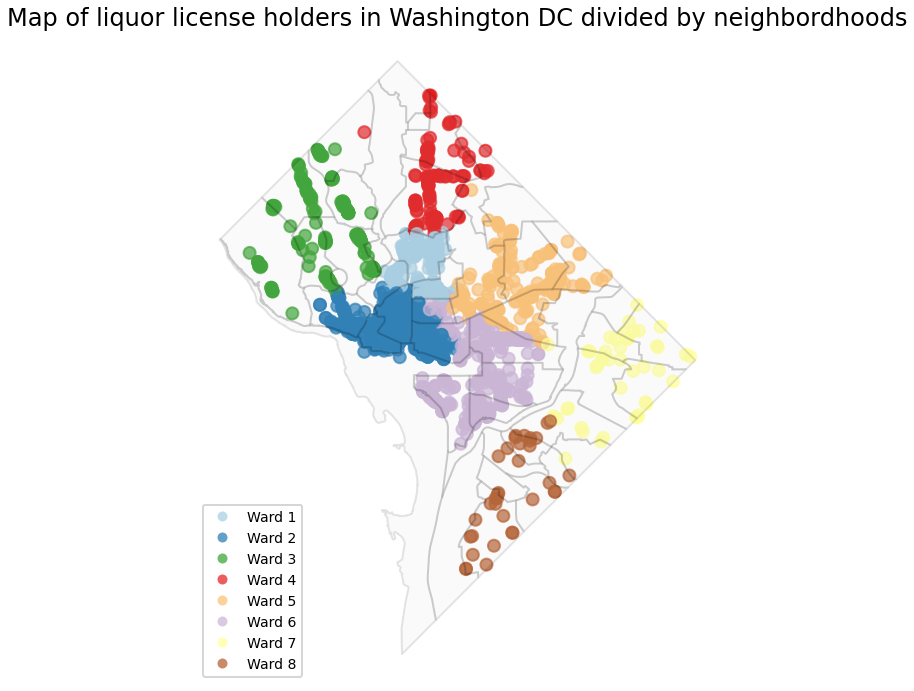

In [18]:
fig

Text(0.5, 1.0, 'Map of liquor license holders in Washington DC')

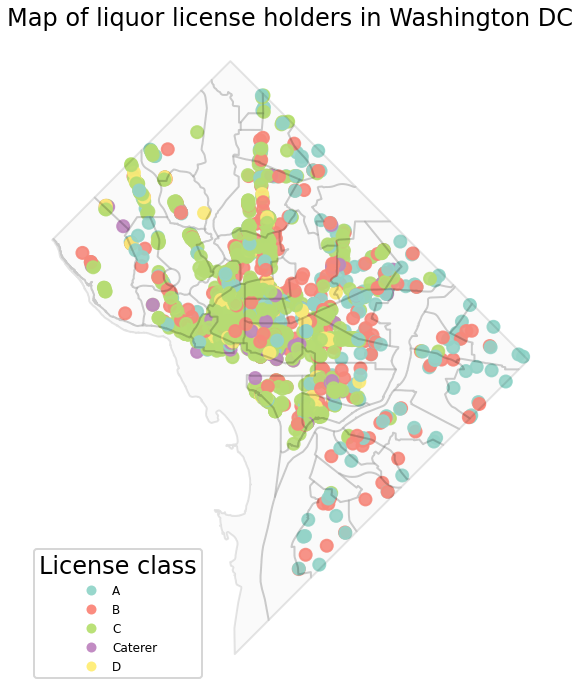

In [19]:
# Color by class

fig, ax= plt.subplots(figsize = (12,12))
geo_df.plot(column = 'CLASS', ax= ax, legend = True,
            legend_kwds={'loc': 'lower left','fontsize':12, "title":"License class"},
            cmap = 'Set3', alpha = 0.9)
neighborhood = gpd.read_file('./Shapefiles/Neighborhood_Clusters.shp')
neighborhood.plot(ax=ax, alpha=0.1, edgecolor='black', color='lightgrey', zorder=2)

frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)
    
# Remove the black box
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.title("Map of liquor license holders in Washington DC")


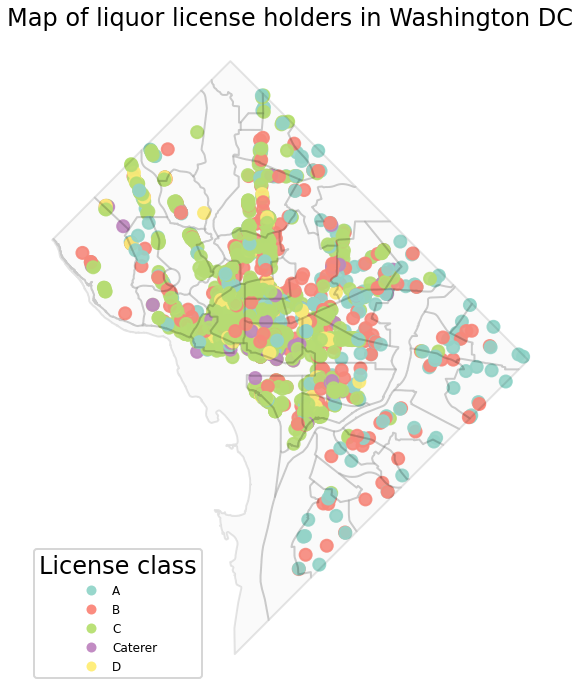

In [20]:
fig

In [21]:
# DBSCAN
import sklearn.cluster as cluster 

# HDBSCAN
### conda install -c conda-forge hdbscan 
import hdbscan 

# DBSCAN (Density-based spatial clustering of applications with noise)

### What does it do?

* Finds objects with more than minimum number of neighbors ($minPts$) within a radius epsilon ($\epsilon$) - these objects are *core points*.

* Finds areas around that core point that satisfy minimum density based on $minPts$ and $\epsilon$ threholds.

* Does not perform density estimation in-between points - all neighbors within the $\epsilon$ radius of a core point are in the same cluster.

### Main tuning parameters:
1) eps: epsilon or the radius of a point in relation to another point to be considered as points in the same neighborhood. NOT the maximum bound on distances of points within a cluster.

2) min_samples: minPts or the number of neighbors within a radius for a point to be considered a core point.

### Weaknesses: 
1) epsilon is a global density threshold, isn’t useful for discovery of clusters with varying degrees of densities.

2) minPts combined with epsilon are not intuitive parameters for areas with varying density levels.

Example: Person A has many neighbors within 100 meters of their apartment in NYC. Person B lives in upstate New York and only have 2 neighbors within the 1 mile radius. DBSCAN counts person A as a core point but not person B. This would not make practical sense for areas with different levels of densities. 

 ### DBSCAN consideration 1: What counts as a core point?
 
 1) Number of neighbors for a point to have to count it as a core point?
 
 ### DBSCAN consideration 2: What to set as epsilon value?

2) DBSCAN does NOT take into account density. Points are further away from one another in rural areas. What is an appropriate epsilon value to capture rural and urban communities?

In [22]:
# Define functions to plot clusters
# Adapted from https://nbviewer.jupyter.org/github/scikit-learn-contrib/hdbscan/blob/master/notebooks/Comparing%20Clustering%20Algorithms.ipynb 
# Also from https://towardsdatascience.com/finding-and-visualizing-clusters-of-geospatial-data-698943c18fed

# Making 2 functions so the plots print different things for DBSCAN and HDBSCAN

def plot_db(data, algorithm, args, kwds):
    
    # Keeping time
    start_time = time.time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    end_time = time.time()
    palette = sns.color_palette('Paired', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    
    # Set figure size                       
    fig, ax = plt.subplots(figsize=(10,10))
    geo_df.plot(c=colors,ax=ax)
    
    # Import DC Neighborhood Shape Files
    neighborhood = gpd.read_file('./Shapefiles/Neighborhood_Clusters.shp')
    neighborhood.plot(ax=ax, alpha=0.4, edgecolor='black', color='lightgrey', zorder=2)

    # Remove x & y axis
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    
    # Remove the black box
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
    labels_count = np.unique(labels).max()
    plt.title('{} '.format(str(labels_count)) + 'clusters found by {}'.format(str(algorithm.__name__)) + ' with epsilon = {} km'.format(str(epsilon)) + ' and min_samples {} neighbors'.format(str(min_samples)), fontsize=14)
    plt.figtext(0.01,0.01,'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)

# DBSCAN example

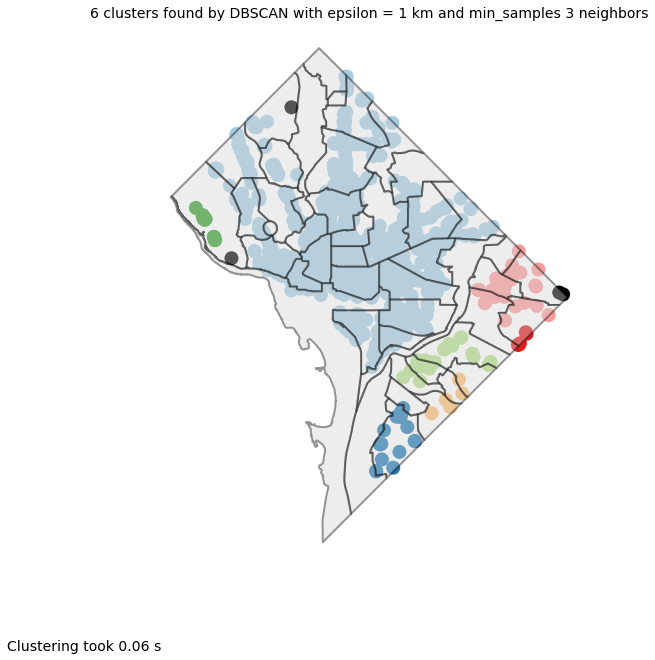

In [34]:
# kilometers
epsilon = 1
# number of neighbors
min_samples = 3
plot_db(X, cluster.DBSCAN, (), {'eps':epsilon/kms_per_radian, 'min_samples':min_samples, 'algorithm':'ball_tree', 'metric':'haversine'})

# Slight detour

* Algorithm = ball tree?
* metric = harversine?

The Balltree algorithm has some nice features, such as the ability to calculate the distance between neighbors with various different distance metrics. Most importantly the function allows to calculate euclidian distance between neighbors (good if your data is in metric crs), as well as haversine distance which allows to determine Great Circle distances between locations (good if your data is in lat/lon format).

https://automating-gis-processes.github.io/site/notebooks/L3/nearest-neighbor-faster.html

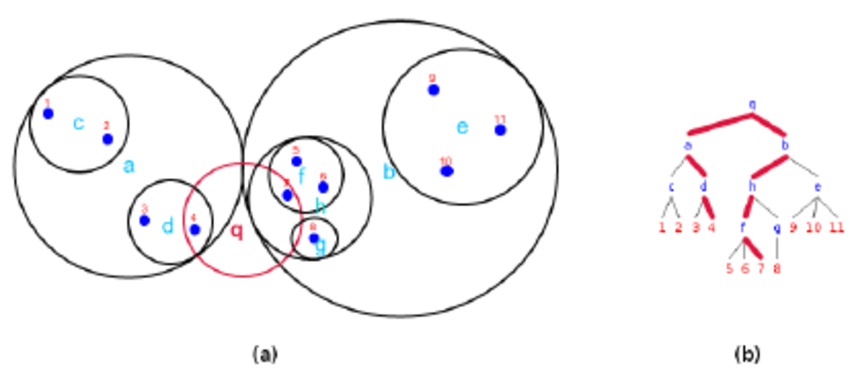

Ball tree partitions and corresponding search tree

# HDBSCAN (Hierarchical Density-based Cluster)


* Allows varying degrees of densities for clusters -> does not need to set an epsilon limit. 

* Starts off similar to DBSCAN: Requires a minimum number of points to form a cluster

* Instead of using a raidus cut off ($\epsilon$) like DBSCAN, HDBSCAN prunes trees. 

### More on pruning trees

HDBSCAN builds a condensed cluster tree. Starting from the root, it prunes the tree. Only considers each cluster split as a “true” split if both child clusters contain at least minPts objects. If they both contains less than minPts objects, the parent cluster disappears at this density level. If one of the children has enough objects but the other doesn’t, then the parent cluster loses points but still exists. The lost points count as noise. 

### Main tuning parameter:

* min_cluster_size

#### Note 1:
min_cluster_size may sound similar to minPts for DBSCAN, but it is not. minPts is used to determine whether a point is a core point, whereas min_cluster_size is to determine the smallest size a blob can be considered a cluster
#### Note 2: 

min_samples also exists as a parameter in HDBSCAN. "The simplest intuition for what min_samples does is provide a measure of how conservative you want your clustering to be. The larger the value of min_samples you provide, the more conservative the clustering – more points will be declared as noise, and clusters will be restricted to progressively more dense areas."

"The amount of data classified as noise is controlled by the min_samples parameter. By default, if not otherwise set, this value is set to the same value as min_cluster_size."

### HDBSCAN consideration 1: What is a sensible number of points to set as minimum for a cluster to form?
 
### HDBSCAN consideration 2: In high density areas, do we want to select the entire blob as one cluster, or do we want many microclusters?
 

In [24]:
# Define functions to plot clusters
# Adapted from https://nbviewer.jupyter.org/github/scikit-learn-contrib/hdbscan/blob/master/notebooks/Comparing%20Clustering%20Algorithms.ipynb 
# Also from https://towardsdatascience.com/finding-and-visualizing-clusters-of-geospatial-data-698943c18fed

# Making 2 functions so the plots print different things for DBSCAN and HDBSCAN

def plot_hdb(data, algorithm, args, kwds):
    
    # Keeping time
    start_time = time.time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    end_time = time.time()
    palette = sns.color_palette('Paired', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    
    # Set figure size
    fig, ax = plt.subplots(figsize=(10,10))
    # Plot the points    
    geo_df.plot(c=colors,ax=ax)

    # Import neighborhood shapefile
    neighborhood = gpd.read_file('./Shapefiles/Neighborhood_Clusters.shp')
    neighborhood.plot(ax=ax, alpha=0.4, edgecolor='black', color='lightgrey', zorder=2)

    # Remove x & y axis
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    
    # Remove the black box
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
    labels_count = np.unique(labels).max()
    plt.title('{} '.format(str(labels_count)) + 'clusters found by {}'.format(str(algorithm.__name__)) + ' with min cluster size = {} points'.format(str(min_cluster_size) + ' and min_samples (noise) = {}'.format(str(min_samples))), fontsize=14)
    plt.figtext(0.01,0.01,'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)

# HDBSCAN example

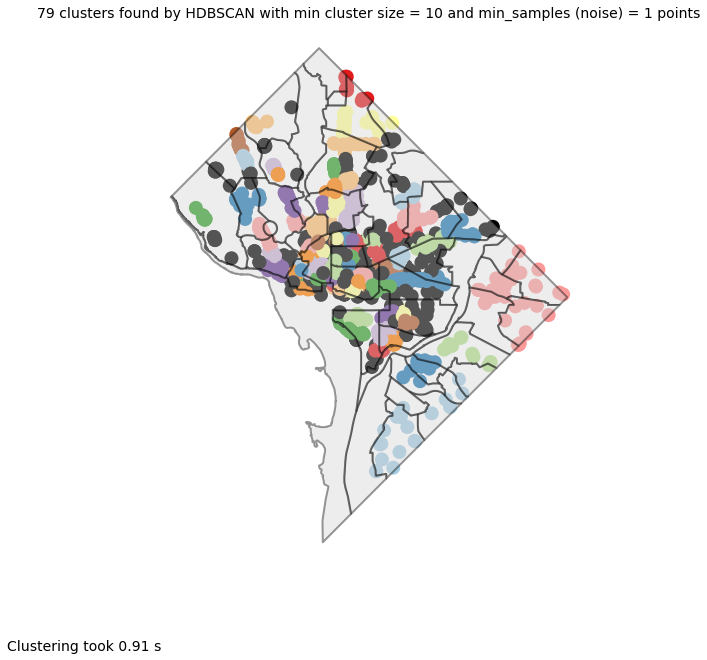

In [37]:
# Set values
min_cluster_size = 10
min_samples = 1
plot_hdb(coords, hdbscan.HDBSCAN, (), {'min_cluster_size':min_cluster_size, 'min_samples' : min_samples, 'metric':'haversine'})

# Hybrid

In [26]:
# https://hdbscan.readthedocs.io/en/latest/how_to_use_epsilon.html

# Define hybrid plotting function


def plot_hybrid(data, algorithm, args, kwds):
    # Keeping time
    start_time = time.time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    end_time = time.time()
    palette = sns.color_palette('Paired', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    # Set figure size
    fig, ax = plt.subplots(figsize=(10,10))
    # Plot the points    
    geo_df.plot(c=colors,ax=ax)

    # Import neighborhood shapefile
    neighborhood = gpd.read_file('./Shapefiles/Neighborhood_Clusters.shp')
    neighborhood.plot(ax=ax, alpha=0.4, edgecolor='black', color='lightgrey', zorder=2)

    # Remove x & y axis
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    
    # Remove the black box
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
    labels_count = np.unique(labels).max()    
    plt.title('{} '.format(str(labels_count)) + 'clusters found by Hybrid' + ' with min cluster size = {}'.format(str(min_cluster_size) + ', min_samples (noise) = {}'.format(str(min_samples)) + ', epsilon = {} km'.format(str(epsilon)) + ', selection method = {}'.format(str(sel_method))), fontsize=14)
    
    plt.figtext(0.01,0.01,'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)    


### Hybrid scenario: We want a cluster to have at least x points, a core point to have at least y neighbors, and the radius to be z km

### Because the minimum number of points to qualify as a cluster is low, HDBSCAN will create many micro-clusters in highly-dense area (the blob in the right hand corner)

### The hybrid method integrates DBSCAN's epsilon into HDBSCAN.

As HDBSCAN prunes its tree, for child nodes that are affected by the min_cluster_size parameter, instead of declaring those points "noise", the hybrid method merges blobs that HDBSCAN doesn't consider full cluster based on min_cluster_size but are within 1km one another.

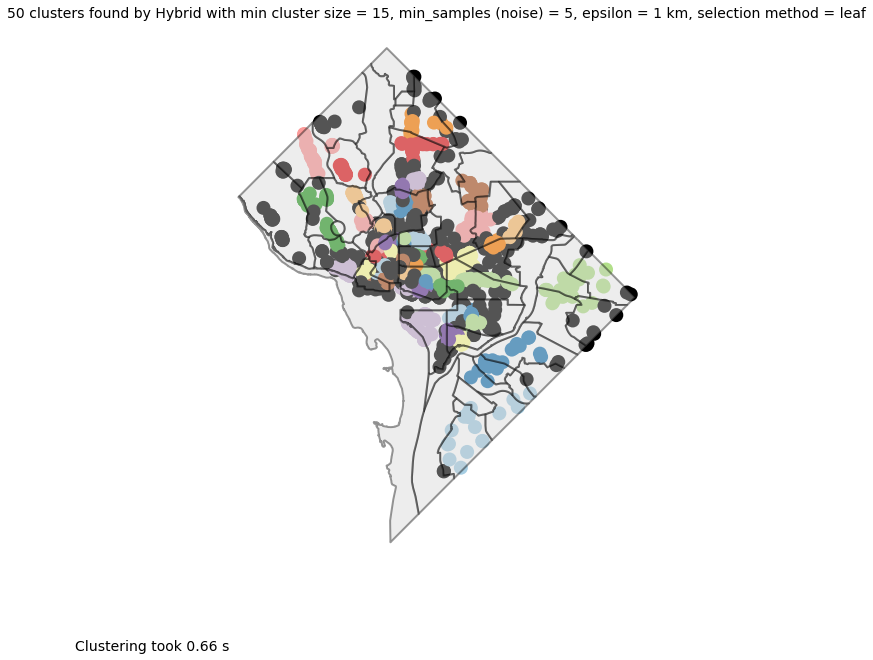

In [38]:
min_cluster_size = 15
min_samples = 5
epsilon = 1 #select for hybrid
# epsilon = 0 #select for pure HDBSCAN

# sel_method = 'eom'
sel_method = 'leaf'

plot_hybrid(coords, hdbscan.HDBSCAN, (), 
            {'min_cluster_size':min_cluster_size, 'min_samples' : min_samples,
             'cluster_selection_epsilon':epsilon/kms_per_radian,
             'cluster_selection_method':sel_method, 'metric':'haversine'})

The 'eom' (Excess of Mass) cluster selection method then returns clusters with the best stability over epsilon.

If you are more interested in having small homogeneous clusters then you may find Excess of Mass has a tendency to pick one or two large clusters and then a number of small extra clusters. In this situation you may be tempted to recluster just the data in the single large cluster. Instead, a better option is to select 'leaf' as a cluster selection method. This will select leaf nodes from the tree, producing many small homogeneous clusters.

In reality, the hybrid scenario makes more sense if you want to cluster samples in a larger geographic area like the NYC/ Upstate NY example or across multiple sparsely inhabited islands in the Phillipines & Manila

# More resources

Interactive Jupyter Notebook extension: RISE https://rise.readthedocs.io/en/stable/


https://hdbscan.readthedocs.io/en/latest/parameter_selection.html

https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html

https://hdbscan.readthedocs.io/en/latest/how_to_use_epsilon.html